In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
tf.random.set_seed(42)
np.random.seed(42)
plt.style.use('ggplot')
%matplotlib inline

In [21]:
data_dir = "C:\\Users\\WDT\\Images"

class_names = sorted(os.listdir(data_dir))
print(f"Number of dog breeds: {len(class_names)}")
print(f"First 5 breeds: {class_names[:5]}")

Number of dog breeds: 120
First 5 breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']


In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_test_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Found 20580 files belonging to 120 classes.
Using 14406 files for training.
Found 20580 files belonging to 120 classes.
Using 6174 files for validation.
Number of training batches: 451
Number of validation batches: 97
Number of test batches: 96


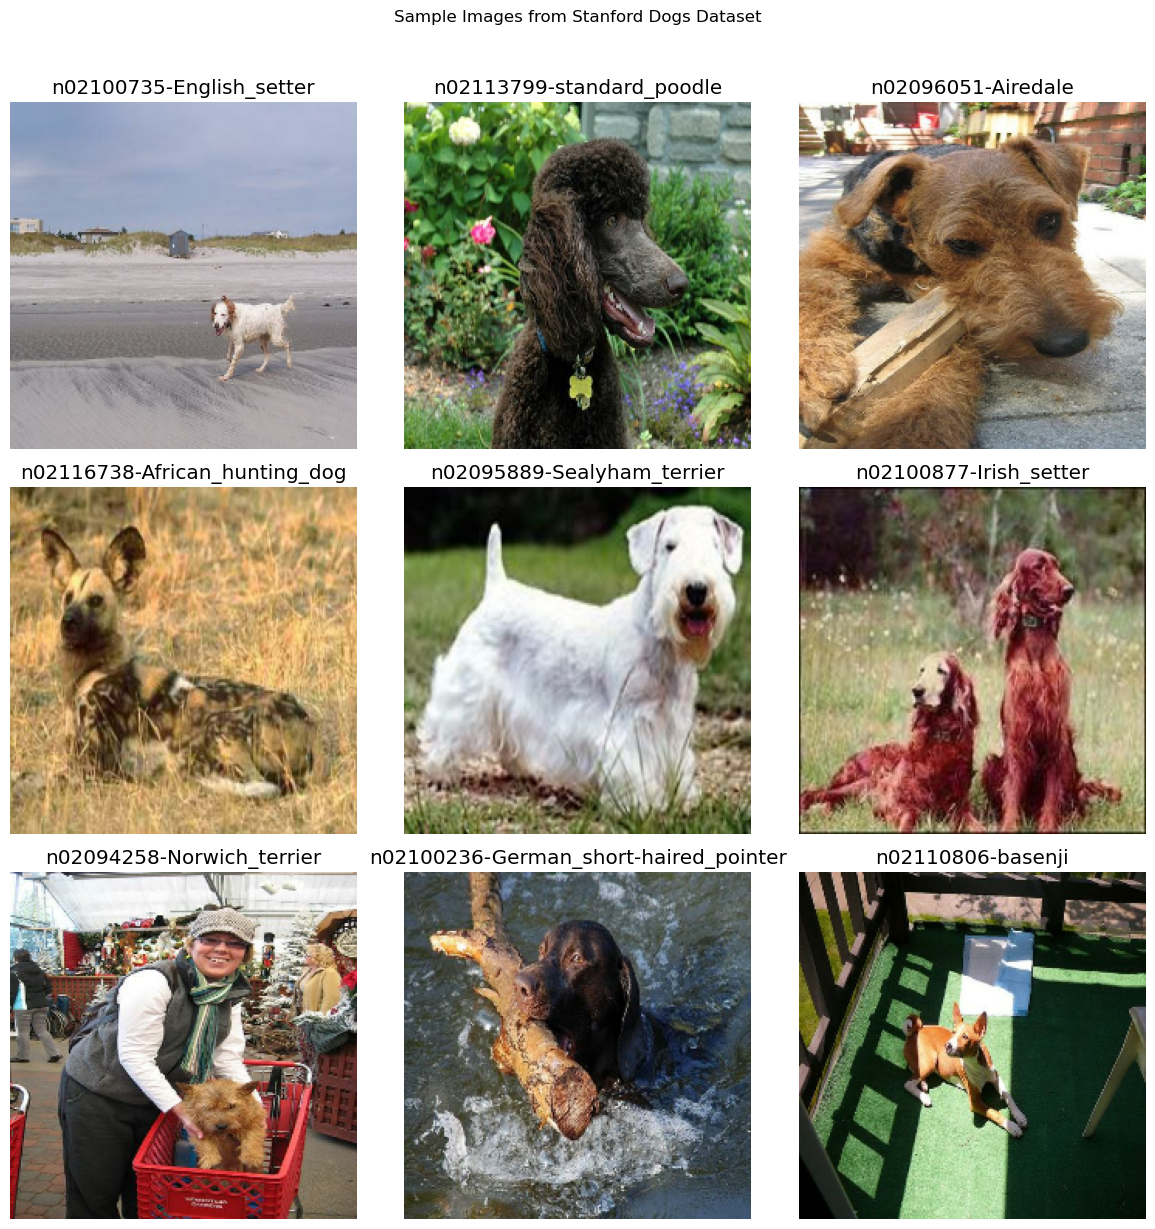

In [23]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Stanford Dogs Dataset", y=1.02)
plt.tight_layout()
plt.show()

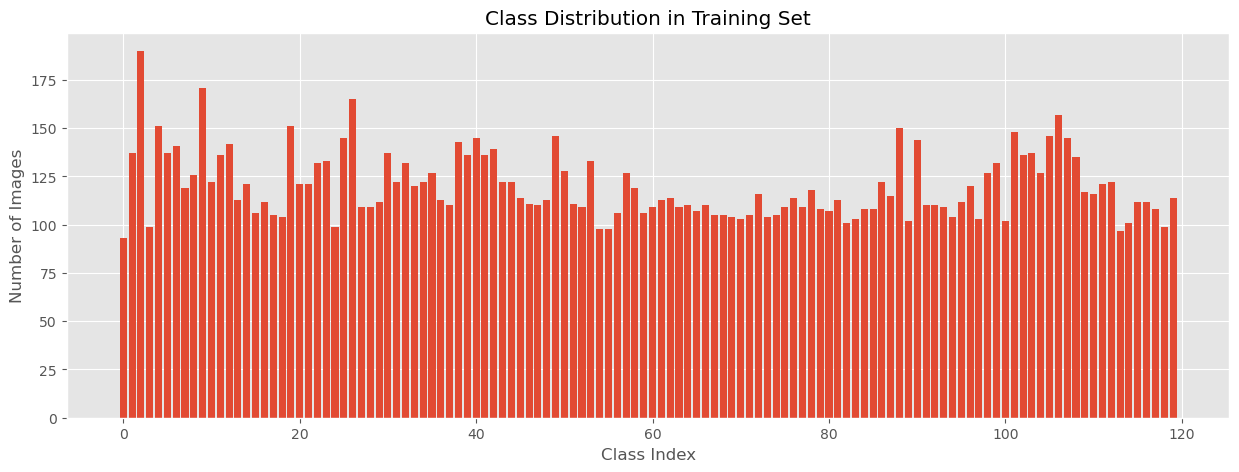


Top 5 most frequent breeds:
n02085936-Maltese_dog: 190 images
n02088094-Afghan_hound: 171 images
n02092002-Scottish_deerhound: 165 images
n02111889-Samoyed: 157 images
n02086240-Shih-Tzu: 151 images

Top 5 least frequent breeds:
n02115913-dhole: 99 images
n02099267-flat-coated_retriever: 98 images
n02099429-curly-coated_retriever: 98 images
n02113624-toy_poodle: 97 images
n02085620-Chihuahua: 93 images


In [24]:
count_dict = {i:0 for i in range(len(class_names))}
for _, labels in train_ds.unbatch():
    count_dict[labels.numpy()] += 1

plt.figure(figsize=(15, 5))
plt.bar(range(len(class_names)), count_dict.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.show()

sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 most frequent breeds:")
for idx, count in sorted_counts[:5]:
    print(f"{class_names[idx]}: {count} images")

print("\nTop 5 least frequent breeds:")
for idx, count in sorted_counts[-5:]:
    print(f"{class_names[idx]}: {count} images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1666718..259.37958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0507202..258.87955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9216003..258.195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [29.239817..239.63347].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.979261..259.00323].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5269642..258.60678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2466593..259

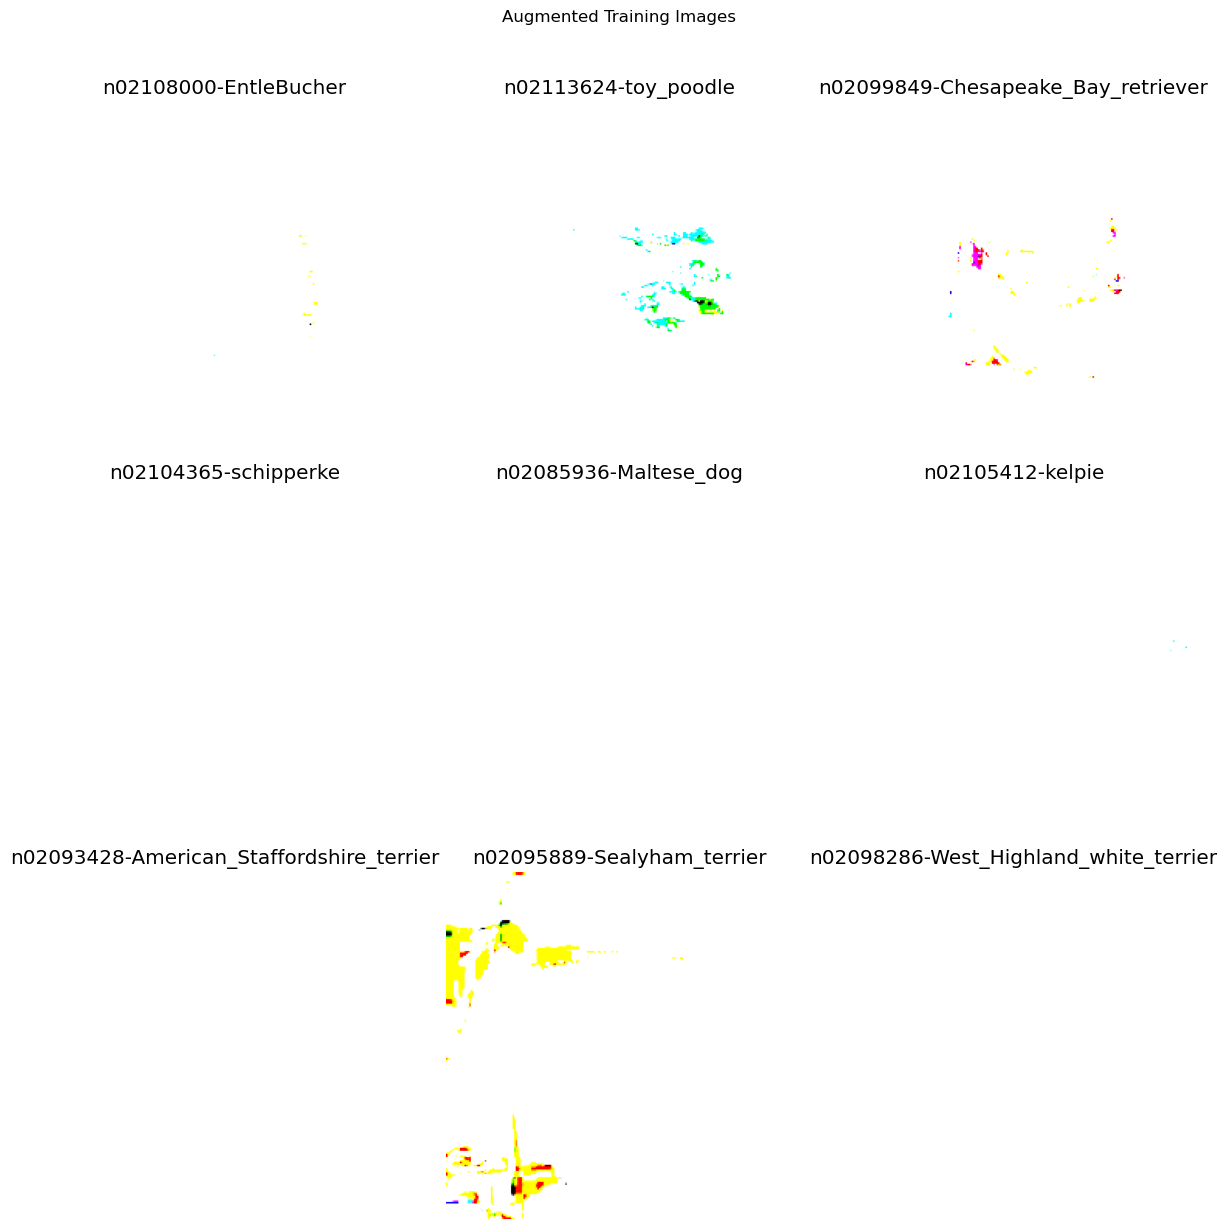

In [25]:
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, IMG_SIZE)
    
    return image, label

train_ds = train_ds.map(augment).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Augmented Training Images", y=1.02)
plt.tight_layout()
plt.show()

In [26]:
def build_cnn_model():
    inputs = keras.Input(shape=(224, 224, 3))
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(120, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = build_cnn_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,176 (1.61 MB)

 Trainable params: 420,216 (1.60 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_scratch_model.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=callbacks
)

451/451 ━━━━━━━━━━━━━━━━━━━━ 1548s 3s/step - accuracy: 0.0180 - loss: 4.7793 - val_accuracy: 0.0219 - val_loss: 4.7242 - learning_rate: 0.0010


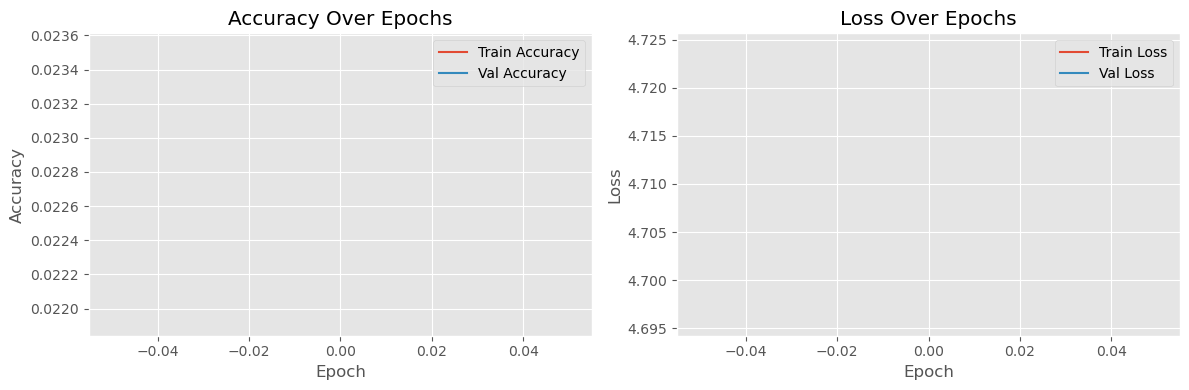

96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.0202 - loss: 4.7278

Test Accuracy: 0.0234
Test Loss: 4.7085


In [28]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    
    plt.tight_layout()
    plt.show()

plot_history(history)

test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Generate predictions
y_true = []
y_pred = []
for images, labels in test_ds.unbatch():
    y_true.append(labels.numpy())
    pred = model.predict(images[np.newaxis, ...])
    y_pred.append(np.argmax(pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Find most confused pairs
confused_pairs = []
for i in range(len(class_names)):
    for j in range(i+1, len(class_names)):
        confused_pairs.append(((i, j), cm[i, j] + cm[j, i]))

# Sort by most confused
confused_pairs.sort(key=lambda x: x[1], reverse=True)

# Print top 5 most confused breed pairs
print("Top 5 most confused breed pairs:")
for (i, j), count in confused_pairs[:5]:
    print(f"{class_names[i]} and {class_names[j]}: {count} misclassifications")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━

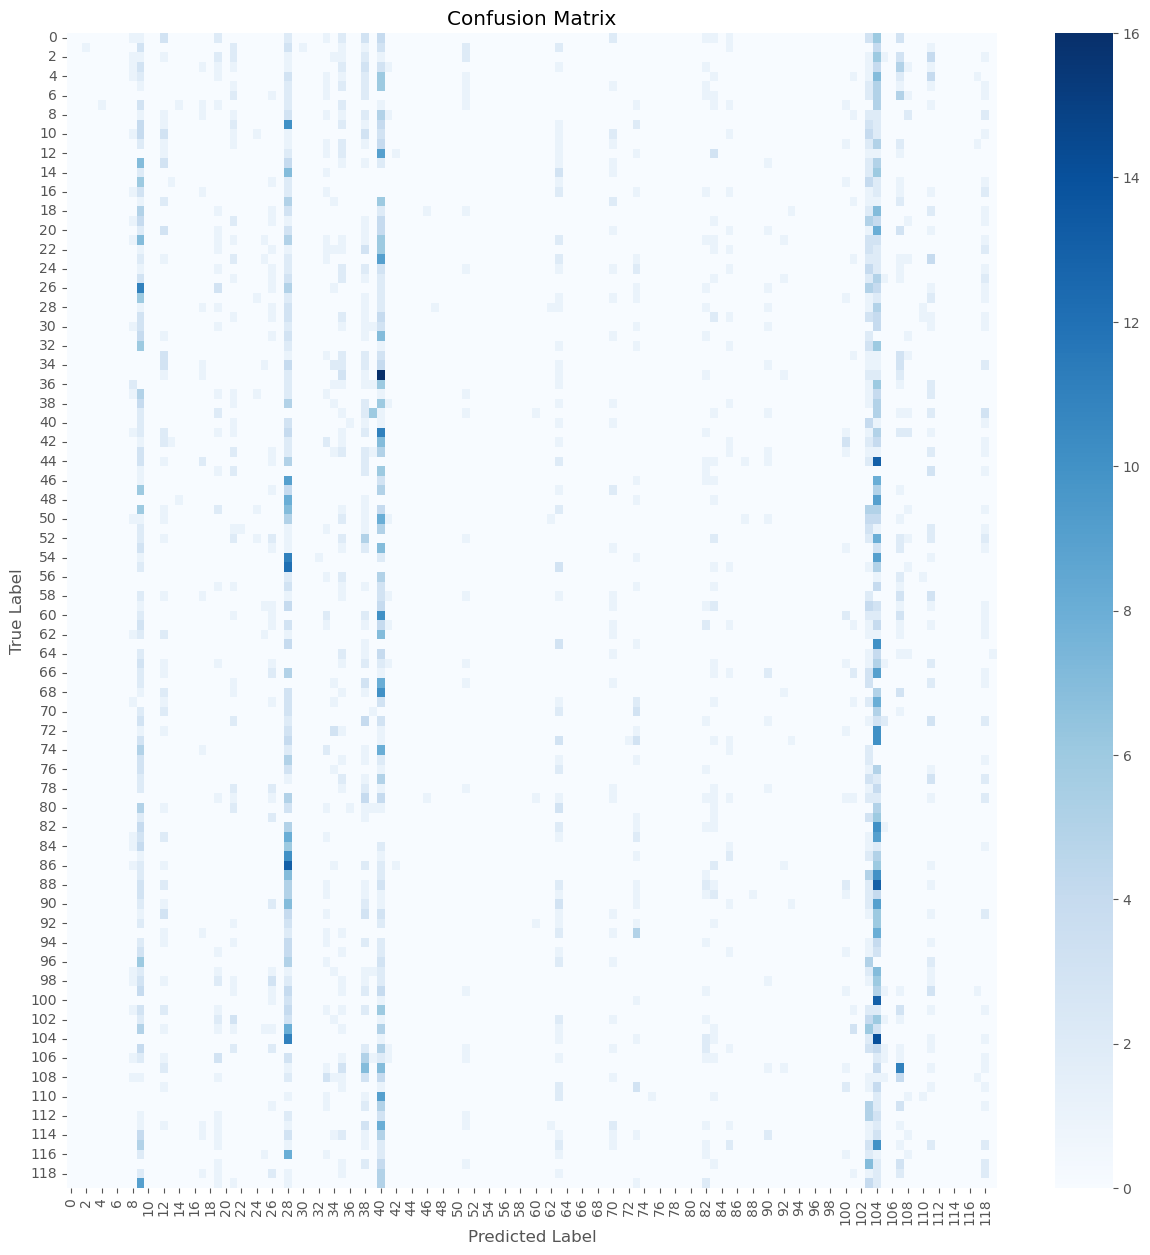

Top 5 most confused breed pairs:
n02093256-Staffordshire_bullterrier and n02111277-Newfoundland: 16 misclassifications
n02094258-Norwich_terrier and n02096051-Airedale: 16 misclassifications
n02093256-Staffordshire_bullterrier and n02107312-miniature_pinscher: 13 misclassifications
n02096585-Boston_bull and n02111277-Newfoundland: 13 misclassifications
n02107683-Bernese_mountain_dog and n02111277-Newfoundland: 13 misclassifications


In [30]:
y_true = []
y_pred = []
for images, labels in test_ds.unbatch():
    y_true.append(labels.numpy())
    pred = model.predict(images[np.newaxis, ...])
    y_pred.append(np.argmax(pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

confused_pairs = []
for i in range(len(class_names)):
    for j in range(i+1, len(class_names)):
        confused_pairs.append(((i, j), cm[i, j] + cm[j, i]))

confused_pairs.sort(key=lambda x: x[1], reverse=True)

print("Top 5 most confused breed pairs:")
for (i, j), count in confused_pairs[:5]:
    print(f"{class_names[i]} and {class_names[j]}: {count} misclassifications")

In [ ]:
def build_transfer_model(base_model_name='EfficientNetB0'):
    if base_model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3))
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(120, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model, base_model

transfer_model, base_model = build_transfer_model()
transfer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

transfer_model.summary()

 1040384/16705208 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step

451/451 ━━━━━━━━━━━━━━━━━━━━ 426s 920ms/step - accuracy: 0.2695 - loss: 3.3544 - val_accuracy: 0.7943 - val_loss: 0.9289
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 399s 884ms/step - accuracy: 0.5960 - loss: 1.5136 - val_accuracy: 0.8221 - val_loss: 0.6705
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 399s 885ms/step - accuracy: 0.6380 - loss: 1.2764 - val_accuracy: 0.8250 - val_loss: 0.6053
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 402s 890ms/step - accuracy: 0.6649 - loss: 1.1664 - val_accuracy: 0.8279 - val_loss: 0.5666
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 409s 907ms/step - accuracy: 0.6778 - loss: 1.0927 - val_accuracy: 0.8308 - val_loss: 0.5454
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 410s 910ms/step - accuracy: 0.6921 - loss: 1.0525 - val_accuracy: 0.8366 - val_loss: 0.5340
Epoch 7/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 410s 910ms/step - accuracy: 0.7080 - loss: 1.0052 - val_accuracy: 0.8385 - val_loss: 0.5243
Epoch 8/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 410s 910ms/step - accuracy: 0.7055 - loss: 0.99

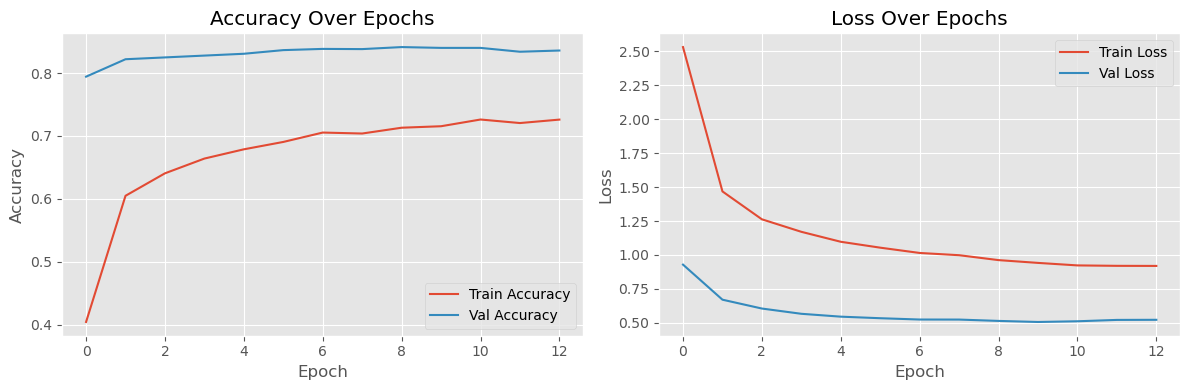

In [32]:
transfer_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("best_transfer_model.keras", save_best_only=True)
    ]
)

test_loss, test_acc = transfer_model.evaluate(test_ds)
print(f"\nTransfer Model Test Accuracy: {test_acc:.4f}")
print(f"Transfer Model Test Loss: {test_loss:.4f}")

plot_history(transfer_history)

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

fine_tune_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("best_fine_tuned_model.keras", save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

test_loss, test_acc = transfer_model.evaluate(test_ds)
print(f"\nFine-tuned Model Test Accuracy: {test_acc:.4f}")
print(f"Fine-tuned Model Test Loss: {test_loss:.4f}")

plot_history(fine_tune_history)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Scratch CNN')
plt.plot(transfer_history.history['val_accuracy'], label='Transfer Learning')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tuned')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.show()

scratch_test_acc = model.evaluate(test_ds)[1]
transfer_test_acc = transfer_model.evaluate(test_ds)[1]

print(f"\nFinal Test Accuracy Comparison:")
print(f"Scratch CNN: {scratch_test_acc:.4f}")
print(f"Transfer Learning: {transfer_test_acc:.4f}")
print(f"Improvement: {(transfer_test_acc - scratch_test_acc)*100:.2f}%")

In [ ]:
# Get a sample image
for images, _ in test_ds.take(1):
    sample_img = images[0]
    break

# Create a model that outputs intermediate activations
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

# Get activations for sample image
activations = activation_model.predict(sample_img[np.newaxis, ...])

# Visualize first layer activations
first_layer_activation = activations[0]
plt.figure(figsize=(15, 5))
plt.suptitle("First Conv Layer Activations", y=1.05)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

last_conv_layer = [layer for layer in model.layers if isinstance(layer, layers.Conv2D)][-1].name
heatmap = make_gradcam_heatmap(sample_img[np.newaxis, ...], model, last_conv_layer)

plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.colorbar()
plt.show()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
superimposed_img = display_gradcam(sample_img, heatmap)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

feature_extractor = keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

features = []
labels = []
for i, (images, batch_labels) in enumerate(test_ds.unbatch().batch(32).take(10)):
    features.append(feature_extractor.predict(images))
    labels.append(batch_labels.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab20', alpha=0.6)
plt.title("t-SNE Visualization of Learned Features")
plt.colorbar(scatter, label='Class Label')
plt.show()